#Research Workshop CSAI 2024 - Group: The Expats - Supervisor: Federico Zamberlan

##Libraries

In [46]:
import pandas as pd
import numpy as np
from scipy.signal import welch
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, median_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

## Dataset

In [47]:
!git clone https://github.com/fzamberlan/dmtreg.git > /dev/null 2>&1

aal90_labels = pd.read_csv("/content/dmtreg/AAL90.csv", delimiter=";", index_col=0)["Label"].to_list()

pre_alpha = pd.read_csv('/content/dmtreg/alpha.csv', names=aal90_labels)
pre_beta = pd.read_csv('/content/dmtreg/beta.csv', names=aal90_labels)
pre_delta = pd.read_csv('/content/dmtreg/delta.csv', names=aal90_labels)
pre_gamma1 = pd.read_csv('/content/dmtreg/gamma1.csv', names=aal90_labels)
pre_gamma2 = pd.read_csv('/content/dmtreg/gamma2.csv', names=aal90_labels)
pre_theta = pd.read_csv('/content/dmtreg/theta.csv', names=aal90_labels)

dmt_alpha = pd.read_csv('/content/dmtreg/DMT_alpha.csv', names=aal90_labels)
dmt_beta = pd.read_csv('/content/dmtreg/DMT_beta.csv', names=aal90_labels)
dmt_delta = pd.read_csv('/content/dmtreg/DMT_delta.csv', names=aal90_labels)
dmt_gamma1 = pd.read_csv('/content/dmtreg/DMT_gamma1.csv', names=aal90_labels)
dmt_gamma2 = pd.read_csv('/content/dmtreg/DMT_gamma2.csv', names=aal90_labels)
dmt_theta = pd.read_csv('/content/dmtreg/DMT_theta.csv', names=aal90_labels)

labels = pd.read_csv('/content/dmtreg/target_labels.txt', header=None)[0].to_list()
target = pd.read_csv('/content/dmtreg/target.csv', names=labels)

subjects = ["Subj "+str(x) for x in range(1,36) if x not in [3, 6, 9, 17, 24, 32]]

#Gradient Boosting Regressor


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'learning_rate': 2, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score (RMSE): 0.8172853563988959
Model RMSE on test data: 0.5201777420748208
Mean Absolute Error: 0.39331723027375204
Median Absolute Error: 0.25
r2: 0.30421029995699156


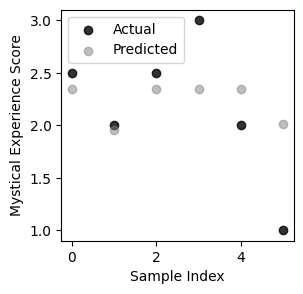

In [58]:

def extract_eeg_features(eeg_data, sf=512):
    features_list = []
    bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 100)}
    for index, row in eeg_data.iterrows():
        feature_row = {}
        for band_name, (fmin, fmax) in bands.items():
            freqs, power = welch(row, sf, nperseg=min(256, len(row)))
            for column in row.index:
                band_power = np.mean(power[(freqs >= fmin) & (freqs <= fmax)])
                feature_row[f'{column}_{band_name}_power'] = band_power
        features_list.append(feature_row)
    return pd.DataFrame(features_list)


aal90_labels = pd.read_csv("/content/dmtreg/AAL90.csv", delimiter=";", index_col=0)["Label"].to_list()
eeg_bands = ['alpha', 'beta', 'delta', 'gamma1', 'gamma2', 'theta']
eeg_data_pre = {band: pd.read_csv(f'/content/dmtreg/{band}.csv', names=aal90_labels) for band in eeg_bands}
eeg_data_dmt = {band: pd.read_csv(f'/content/dmtreg/DMT_{band}.csv', names=aal90_labels) for band in eeg_bands}
target = pd.read_csv('/content/dmtreg/target.csv', names=['Mystical Experience'])

features_dmt = pd.concat([extract_eeg_features(eeg_data_dmt[band]) for band in eeg_bands], axis=1)


imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features_dmt)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)


selector = SelectKBest(score_func=f_regression, k=20)
features_selected = selector.fit_transform(features_scaled, target.values.ravel())


feature_names = features_dmt.columns
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = feature_names[selected_feature_indices]


X_train, X_test, y_train, y_test = train_test_split(features_selected, target.values.ravel(), test_size=0.2, random_state=12)

param_grid = {
'learning_rate': [0.01, 0.02, 0.1, 1, 2],
'max_depth': [3, 5, 7],
'min_samples_split': [2, 5],
'min_samples_leaf': [0.1, 1, 5],
'n_estimators': [100, 200]
}
model = GradientBoostingRegressor(random_state=12)


kf = KFold(n_splits=5, shuffle=True, random_state=12)


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=1)


grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_


predictions = best_model.predict(X_test)


mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)
median_ae = median_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)


print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (RMSE):", np.sqrt(-grid_search.best_score_))
print("Model RMSE on test data:", rmse)
print("Mean Absolute Error:", mae)
print("Median Absolute Error:", median_ae)
print("r2:", r2)


plt.figure(figsize=(3, 3))
plt.scatter(range(len(y_test)), y_test, color='black', label='Actual', alpha=0.8)
plt.scatter(range(len(predictions)), predictions, color='grey', label='Predicted', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Mystical Experience Score')
plt.legend()
plt.show()

importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)



Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 7, 'learning_rate': 0.01}
Best cross-validation score (RMSE): 0.7990149181952312
Model RMSE on test data: 0.5028840529792769
Mean Absolute Error: 0.3794733510779183
Median Absolute Error: 0.28102089341456304
r2: 0.18050067202960463


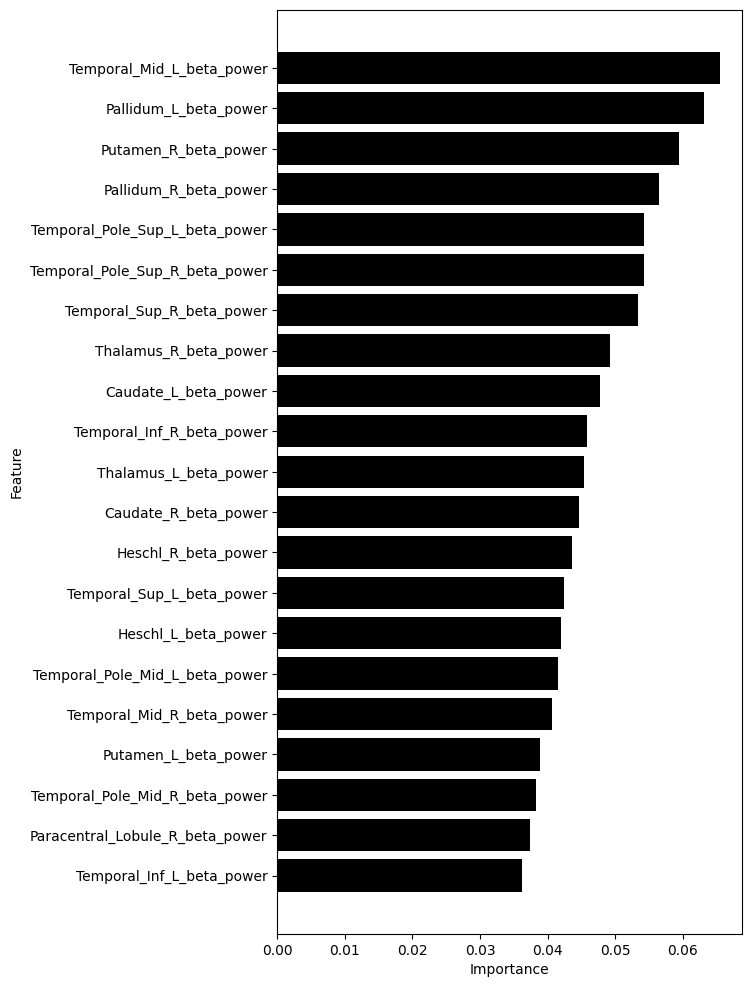

In [52]:
# Plot feature importances
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': selected_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(6, 12))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='black')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.gca().invert_yaxis()
plt.show()
